# Initial processing
This is a sample workflow for initial processing steps, including filtering and scVI denoising of the data. We use as an example Dataset D1, which is *E. coli* grown in LB.

The scripts used to generate the count matrices from raw fastq files are available at https://tavazoielab.c2b2.columbia.edu/PETRI-seq/, with light adaptation to allow gene-level feature mapping rather than operon-level mapping.

All data, including fastq files, count matrices, and associated metadata are available as part of the GEO series GSE217715.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scvi

# Set plotting parameters
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### 1. Importing and filtering
We import the count matrices for the full PETRI-seq run and filter these for the correct sample and desired UMI per cell:

In [2]:
# Get file names
counts_dir="count_matrices/"
files = [counts_dir + f for f in os.listdir(counts_dir) if '_counts.txt.gz' in f]

# Import counts as individual libraries that are then concatenated together
# (if there are mismatches between libraries in terms of genes, these are filled in with zeros)
counts = pd.concat([pd.read_table(file, sep="\t", index_col=0) for file in files]).fillna(0)

# Remove chromosome names from gene labels
counts.columns = counts.columns.str.replace("^NC_.*:", "", regex=True)
counts

,b0001,b0002,b0003,b0004,b0005,b0006,b0007,b0008,b0009,b0010,...,b4753,b1032,b1373,b3045,b4100,b4513,b4588,b1574,b1546,b4747
Cell Barcode,,,,,,,,,,,,,,,,,,,,,
D1_lib8_bc1_10_bc2_10_bc3_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D1_lib8_bc1_10_bc2_10_bc3_67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D1_lib8_bc1_10_bc2_10_bc3_74,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D1_lib8_bc1_10_bc2_11_bc3_12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D1_lib8_bc1_10_bc2_11_bc3_34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D1_lib7_bc1_9_bc2_96_bc3_37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D1_lib7_bc1_9_bc2_96_bc3_55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D1_lib7_bc1_9_bc2_9_bc3_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we remove all rRNA features. Our standard mapping pipeline does a poor job of quantifying rRNAs, likely because they are encoded by multicopy genes (and so cannot be mapped uniquely by FeatureCounts). As such, we find it best to remove all rRNA features prior to analysis. These can be extracted from the GFF file:

In [3]:
# Import and process the GFF
gff = pd.read_csv("reference/GCF_000005845.2_ASM584v2_genomic.gff.gz",
                 sep="\t", comment='#', names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
chrom_length = gff.loc[0, 'end']

gff['name'] = gff['attribute'].str.replace("^.*;Name=", "", regex=True).str.replace(";.*$", "", regex=True)
gff['locus_tag'] = gff['attribute'].str.replace("^.*;locus_tag=", "", regex=True).str.replace(";.*$", "", regex=True)

# Select rRNA genes
rRNA_genes = gff.loc[gff['feature'] == 'rRNA', 'locus_tag']

# Filter out rRNA genes
print('Number of features before filtering: ' + str(counts.shape[1]))
counts = counts.loc[:,~np.isin(counts.columns, rRNA_genes)]
print('Number of features after filtering: ' + str(counts.shape[1]))

Number of features before filtering: 4392
Number of features after filtering: 4375


Next, we want to filter to extract only the LB grown cells (this dataset also contains the M9GA and M9G data). For PETRI-seq, samples are encoded as the bc1, which can be extracted from the index of the counts matrix:

In [4]:
# Construct a vector that can be used to convert bc1 indices into sample names
bc1_lookup = []
for i in range(1,97):
    if i <= 36:
        bc1_lookup.append('LB')
    elif 36 < i <= 72:
        bc1_lookup.append('M9_Glc_AA')
    elif 72 < i <= 96:
        bc1_lookup.append('M9_Glc')
    else:
        raise ValueError (str(i) + ' should not be a value.')
bc1_lookup = np.array(bc1_lookup)

# Extract the bc1 indices from the cell barcode names
bc1 = counts.index.str.replace('D1_lib\d_bc1_', '', regex=True).\
    str.replace('_bc2_.*', '', regex=True).astype(int)

# Convert bc1 to sample and quantify indices per sample
sample_label = pd.Series(bc1_lookup[bc1.to_numpy() - 1], index=counts.index)
sample_label.value_counts()

LB           109214
M9_Glc_AA     71464
M9_Glc        57016
dtype: int64

Filter for only LB-grown cells (barcodes 1:36, the first three rows of the 96-well barcoding plate). At this point we can also save the counts matrix to come back to:

In [5]:
counts = counts.loc[sample_label == 'LB']
counts.to_csv('outputs/lb_raw_counts.txt.gz',
              index=True, index_label='CellBarcode', sep="\t"
             )

Next we create an AnnData object to enable handling and filtering of the data via scanpy (https://scanpy.readthedocs.io/en/stable/):

In [6]:
adata = sc.AnnData(counts)

We calculate metrics for filtering the data and plot a histogram of UMI/barcode:

/opt/anaconda3/envs/scvi-env/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:399: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


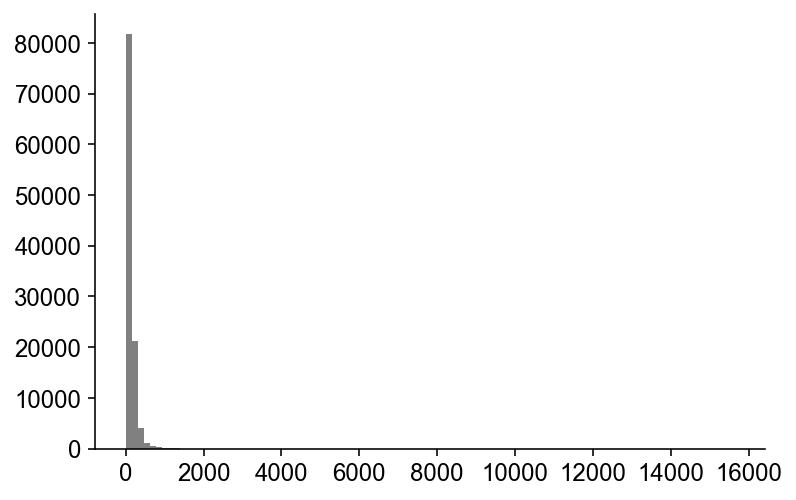

In [7]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
plt.hist(adata.obs['total_counts'], bins=100, color='grey')
plt.show()

Unfortunately this is not very informative due to the presence of outliers. If we control the axis limits, we get something more useful:

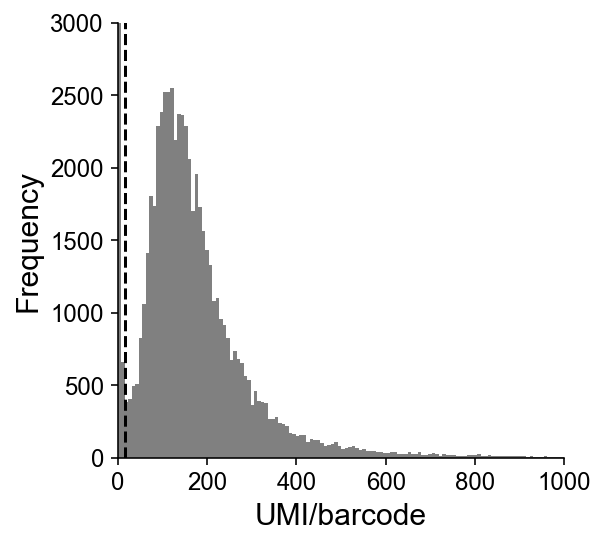

In [8]:
plt.figure(figsize=(4,4))
plt.hist(adata.obs['total_counts'], bins=2000, color='grey')
plt.vlines(15, 0, 5000, color='black', linestyles='dashed')
plt.xlim(0, 1000)
plt.ylim(0, 3000)
plt.xlabel('UMI/barcode', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

This shows us that there is a large buildup of barcodes close to zero, which declines and then forms a separate distribution after an inflection point. We typically use this inflection point to manually set the minimum UMI/barcode threshold. We next filter as follows:

In [9]:
sc.pp.filter_cells(adata, min_counts=15, inplace=True)
sc.pp.filter_cells(adata, max_counts=2000, inplace=True)
sc.pp.filter_genes(adata, min_counts=50, inplace=True)
adata.shape

(57627, 3070)

Finally we save the AnnData object:

In [10]:
adata.write('outputs/lb_adata.h5ad')

### 2. scVI denoising
Even after filtering, we can see that the expression matrix is still very sparse. The following shows us that >96% of cell values are zero:

In [11]:
100 * np.sum(adata.X.flatten() == 0) / (len(adata.X.flatten()))

96.19982749897423

Therefore, we use scVI (https://scvi-tools.org/) to generate a smoothed version of the data.

Since fitting models via scVI is non-deterministic, running this code will give you a slightly different version of the model from that used in the manuscript. To get the exact model used, load the parameters from `samples/D1_scVI_model`.

We adopt the chosen hyperparameters based on a previous hyperparameter search (see manuscript for details).

In [12]:
scvi.data.setup_anndata(adata) # Required setup step
model = scvi.model.SCVI(adata, # Training the model
                        n_layers=2,
                        n_latent=5,
                        n_hidden=64,
                        dropout_rate=0.1,
                        gene_likelihood='zinb',
                        dispersion='gene'
                       )
model.train()
model.save('outputs/lb_scVI_model') # Save. Note by default this does not overwrite, so rerunning 
                                    # this cell without deleting the old folder will fail.

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 57627 cells, 3070 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Epoch 139/139: 100%|██████████| 139/139 [35:29<00:00, 15.32s/it, loss=368, v_num=1]


This saves the model for future use. To reload the model we can do the following:

`adata = sc.read_h5ad('outputs/lb_adata.h5ad')`

`model = scvi.model.SCVI.load('outputs/lb_scVI_model', adata)`

The denoised counts matrices are much larger than the raw counts (because they cannot be compressed efficiently), so we typically load the denoised counts matrices in this manner. 

### 3. Doing chromsome-wide correlation analysis
We can take this scVI-denoised data and use it to uncover the chromosome-wide correlation patterns.

First, we have to import the GFF again and recenter it so that the origin is at position zero:

In [3]:
gff = pd.read_csv("reference/GCF_000005845.2_ASM584v2_genomic.gff.gz",
                 sep="\t", comment='#', names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
chrom_length = gff.loc[0, 'end']

gff['name'] = gff['attribute'].str.replace("^.*;Name=", "", regex=True).str.replace(";.*$", "", regex=True)
gff['locus_tag'] = gff['attribute'].str.replace("^.*;locus_tag=", "", regex=True).str.replace(";.*$", "", regex=True)

gff = gff[gff['feature'] == 'gene'] # Filter for only genes
gff = gff[['chrom', 'start', 'end', 'strand', 'name', 'locus_tag']]
gff.reset_index(inplace=True)

# Set the starting position of each gene (depending on strand)
def set_coord(x):
    if x['strand'] == '+':
        return x['start']
    elif x['strand'] == '-':
        return x['end']
    else:
        raise ValueError('Strand should not be ' + x['strand'])

gff['coord'] = gff.apply(set_coord, axis=1)
gff.index = gff['locus_tag']

# Start of the replication origin - Taken directly from the genbank annotation
origin_start = 3925744
origin_end = 3925975
origin_midpoint = (origin_start + origin_end + 1) / 2 # The +1 gives the origin an integer value
origin_midpoint

# Reset the start coordinate so that the origin is at zero, then sort the GFF by this value
gff = gff.loc[pd.Series(adata.var_names),:]
gff['coord'] = (gff['coord'] - origin_midpoint) % chrom_length
gff = gff.sort_values('coord')

# Filter out extrachromosomal genes (important for genomes with extrachromosomal elements):
gff = gff.loc[gff['chrom'] == 'NC_000913.3']

gff.head()

,index,chrom,start,end,strand,name,locus_tag,coord
locus_tag,,,,,,,,
b3742,8013,NC_000913.3,3926012,3926455,-,mioC,b3742,595.0
b3743,8015,NC_000913.3,3926545,3927003,-,asnC,b3743,1143.0
b3744,8017,NC_000913.3,3927155,3928147,+,asnA,b3744,1295.0
b3745,8019,NC_000913.3,3928152,3929603,-,viaA,b3745,3743.0
b3746,8021,NC_000913.3,3929597,3931093,-,ravA,b3746,5233.0


Now do the gene-gene correlations (initially without binning - this can take some time):

<AxesSubplot:xlabel='locus_tag', ylabel='locus_tag'>

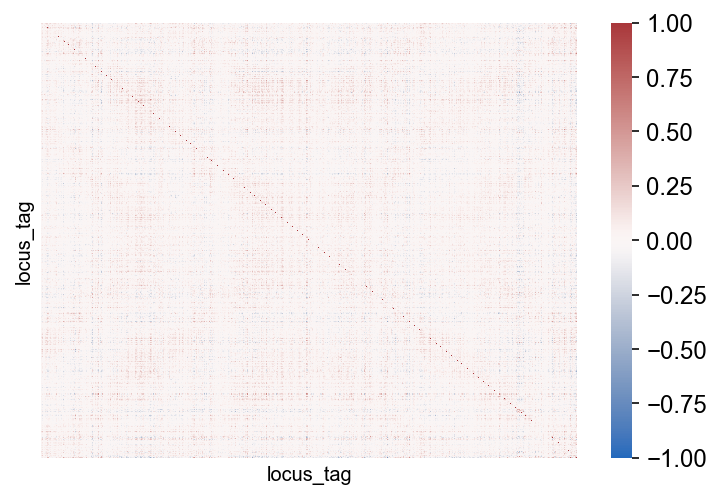

In [4]:
cors = model.get_feature_correlation_matrix(adata)

# Plot (in order of chromosomal location starting from the origin)
sns.heatmap(cors.loc[gff.index, gff.index],
            cmap='vlag', vmin=-1, vmax=1, center=0,
            xticklabels=False, yticklabels=False)

As we can see, the correlations are very weak and it's not that informative. However, if we restrict the color scale to see weaker correlations, the pattern emerges:

<AxesSubplot:xlabel='locus_tag', ylabel='locus_tag'>

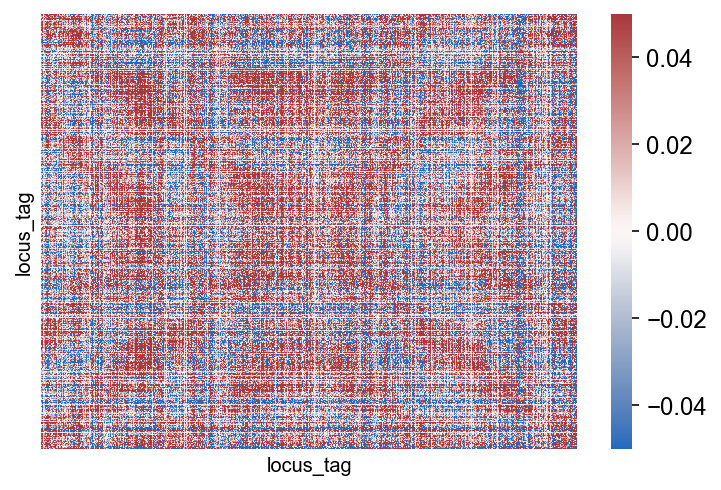

In [5]:
sns.heatmap(cors.loc[gff.index, gff.index],
            cmap='vlag', vmin=-0.05, vmax=0.05, center=0,
            xticklabels=False, yticklabels=False)

Next, we can create bins by chromosomal location to enhance this position-dependent signal:

In [6]:
from collections import OrderedDict
from scipy.stats import spearmanr


### Function to create bins
# This creates an ordered dictionary where each key is a chromosomal region and each key is a list of genes
# in that bin.
def create_bins(gff, chrom_length, bin_size):
    bins = OrderedDict()
    if type(bin_size) is float:
        bin_size = int(bin_size)
    for bin_start in range(1, chrom_length + 1, bin_size):
        bin_end = bin_start + bin_size - 1
        if bin_end > chrom_length:
            bin_end = chrom_length
        bins[(bin_start, bin_end)] = list(gff.loc[(bin_start <= gff['coord']) & (gff['coord'] <= bin_end), 'locus_tag'])
    return bins

### Function to create binned expression
# This takes the bin dictionary and averages gene expression within each bin.
def bin_expression(counts, bins):
    bin_names = []
    binned_expression = []
    for bin in bins:
        bin_names.append((bin[0] + bin[1]) / 2)
        binned_expression.append(counts.loc[:,np.isin(counts.columns, bins[bin])].mean(axis=1))
    binned_expression_df = pd.DataFrame(binned_expression).transpose()
    binned_expression_df.columns = bin_names
    return binned_expression_df

Having defined these functions, we generate normalized, scaled expression from the scVI output and use it to create chromosome position-binned expression data. From this, we generate chromosome-wide correlation patterns where the signal is greatly strengthened.

<AxesSubplot:>

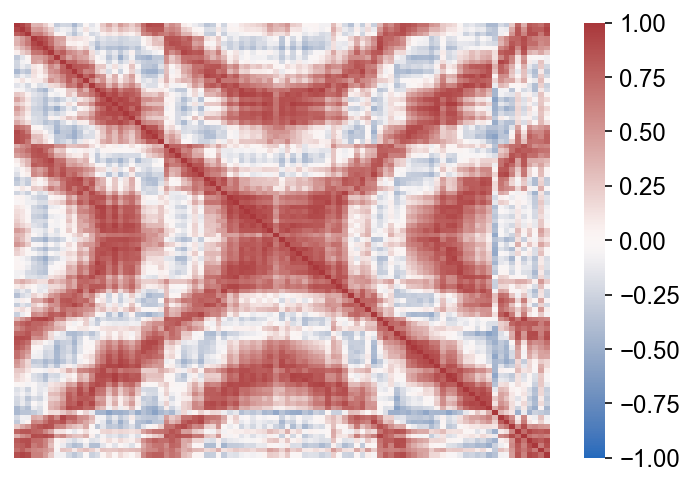

In [7]:
# Get scVI-normalized expression and scale it
normalized_expression = model.get_normalized_expression(adata)
normalized_expression = normalized_expression[gff.index] # Sort by origin-zeroed chromosomal location
log_expression = np.log2(normalized_expression)
scaled_expression = log_expression.apply(lambda x: (x - np.mean(x)) / np.std(x), 0)

# Create bins and use these to bin expression (chrom length taken from the GFF file above)
bins = create_bins(gff, chrom_length, 5e4)
binned_expression = bin_expression(scaled_expression, bins)

bin_cors = spearmanr(binned_expression)[0]
sns.heatmap(bin_cors, center=0, vmin=-1, vmax=1, cmap='vlag', xticklabels=False, yticklabels=False)